In [1]:
# 1. Importando as bilbiotecas de interesse
from fenics import *
import numpy as np
import os
import shutil
import time
import matplotlib.pyplot as plt

# 1.1. Importando as propriedades
# from propriedades_5CAC import *
g = Constant(9.81)
w_c = Constant(300.0)
w_0 = Constant(100.0)

ffc_options = {"quadrature_degree": 6, "optimize": True}

def rho_s(T):
    rho_val = 2500
    return rho_val


def C_p(T):
    C_p_val = 900
    return C_p_val


def lmbda(P_v, T):
    lmbda_val = 1.265
    return lmbda_val


# Antoine pressure
def P_s(T):
    C_1 = -5800.2206
    C_2 = 1.3914993
    C_3 = -4.8640239e-2
    C_4 = 4.1764768e-5
    C_5 = -1.4452093e-8
    C_6 = 6.5459673
    Pvps_vals = exp(C_1 / T + C_2 + C_3 * T + C_4 * T**2 + C_5 * T**3 +
                    C_6 * ln(T))
    return Pvps_vals


def w_d(T):
    A1 = 13; A2 = 33.5; A3 = 20; K1 = 20; K2 = 7; K3 = 5; L1 = 205; L2 = 310; L3 = 500;
    K4 = 1; L4 = 540; LA = 0.02; LB = 0
    x = T-273.15
    val  = A1*(1-exp(-(x/L1)**K1))
    val += A2*(1-exp(-(x/L2)**K2))
    val += A3*(1-exp(-(x/L3)**K3))
    val += (LA*x + LB) * (exp(-(x/L4)**K4))
    return (val + abs(val))/2


def dw_ddt(T, T_n):
    delta = 1e-8
    dT = delta * T_n
    dw_ddT = ((w_d(T_n + dT / 2) - w_d( T_n - dT / 2)) / (dT))
    dTdt = (T - T_n) / dt
    return dw_ddT * dTdt

# Relative humidity
def h(P_v, T):
    return P_v / P_s(T)

def m(T):
    return 1.04 - ((T - 263.15)**2) / ((T - 263.15)**2 +
                                       22.34 * (298.15 - 263.15)**2)

def w_1(P_v, T):
    return w_c * ((w_0 / w_c) * (h(P_v, T)))**(1 / m(T))

def w_2(P_v, T):
    return w_c * (0.037 * (h(P_v, T) - 1.04) +
                                          (w_0/w_c) * (1.0 - ((T - 273.15)**2.0) / (3.6e5)))

def w(P_v, T):
        w_096 = w_1(0.96 * P_s(T), T)
        w_104 = w_2(1.04 * P_s(T), T)
        w_int = w_096 + ((w_104 - w_096) * (h(P_v, T) - 0.96) / 0.08)
        return conditional(le(T, 647.15),
                       conditional(le(h(P_v, T), 0.96), w_1(P_v, T),
                                   conditional(le(h(P_v, T), 1.04), w_int,
                                               w_2(P_v, T))), 0.0)

def dwdt(P_v, T, P_v_n, T_n):
    delta = 1e-4
    dP = delta * P_v_n
    dT = delta * T_n
    dwdP = ((w(P_v_n + dP / 2, T_n) - w(P_v_n - dP / 2, T_n)) / (dP))
    dwdT = ((w(P_v_n, T_n + dT / 2) - w(P_v_n, T_n - dT / 2)) / (dT))
    dPdt = (P_v - P_v_n) / dt
    dTdt = (T - T_n) / dt
    return dwdP * dPdt + dwdT * dTdt


def C_a(T):
    return conditional(le(T, 647.3), 3.5e5 * ((647.3 - T)**(1 / 3)), 0.0)


C_w = Constant(4100.0)
def C_p_l(T):
    return C_w

a_0 = Constant(1.0839648370802355e-10)

def a(P, T):
    return a_0

# from utils import *
def criar_pasta(case_name):
    '''
    Função para criar um diretório para armezanar os resultados de uma
    simulação.

    Parametros
    ----------
    case_name: str
        Nome do caso a ser simulado.

    Returna
    -------
    dir_saida: str
        Endereço do diretório de saída.

    dir_local: str
        Endereço do diretório local da onde se roda a simulação.


    Notas:
    ---
    Nenhum.

    '''
    dir_saida = f'./resultados/{case_name}'
    dir_local = os.getcwd()
    if not os.path.exists(dir_saida):
        os.mkdir(dir_saida)
    return dir_saida, dir_local

# os.mkdir(f'./resultados')

print(f'| Bibliotecas importadas com sucesso!')
print('----------------------------------------')

# 2. Definição do nome do caso
case_name = 'real_case_2D'
print(f'| Rodando o caso: "{case_name}"...')

# 3. Criação da pasta de resultados do caso
dir_saida, dir_local = criar_pasta(case_name)
print('|--- Pasta criada com sucesso!')

# 4. Criação dos backups
# # 4.1. Backup da Simulação
# shutil.copy(dir_local + '/Fake Simulation.ipynb',
#             dir_saida + '/backup_' + case_name + '.ipynb')
# 4.2. Backup das Propriedades
# shutil.copy(dir_local + '/propriedades_5CAC.py',
#             dir_saida + '/backup_propriedades.py')
# print('|--- Back-up criado com sucesso!')

# # 5. Criação da malha
# def criar_malha():
#     '''

#     '''

#     lx = 1
#     ly = 3
#     nx = 10
#     ny = 30
#     malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)

#     flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
#     flags.set_all(0)

#     class top(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[1], ly, 1e-2)


#     class bottom(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[1], 0, 1e-2)


#     class left(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[0], 0, 1e-2)


#     class right(SubDomain):
#         def inside(self, x, on_boundary):
#             return on_boundary and near(x[0], lx, 1e-2)

#     top = top()
#     bottom = bottom()
#     left = left()
#     right = right()

#     top.mark(flags, 1)
#     bottom.mark(flags, 2)
#     left.mark(flags, 3)
#     right.mark(flags, 4)

#     print('|--- Malha criada com sucesso!')
#     return malha, flags

# malha, flags = criar_malha()

# 5. Criação da malha
def criar_malha():
    lx = 130 / 1000 # comprimento (no sentido dos sensores)
    ly = 114 / 1000 # largura
    lz = 100 / 1000 # altura
    nx = int(lx * 1000 // 4)
    ny = int(ly * 1000 // 4 )
    nz = int(lz * 1000 // 4 )
#     malha = IntervalMesh(nx, 0, lx)
    malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)
#     malha = BoxMesh(Point(0, 0, 0), Point(lx, ly, lz), nx, ny, nz)


    flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
    flags.set_all(0)

    class hotface(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, 1e-2)

    class coldface(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], lx, 1e-2)

    # class top(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[1], ly, 1e-2)

    # class bottom(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[1], 0, 1e-2)

    # class left(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[0], 0, 1e-2)

    # class right(SubDomain):
    #     def inside(self, x, on_boundary):
    #         return on_boundary and near(x[0], lx, 1e-2)

    hotface = hotface()
    coldface = coldface()
    # top = top()
    # bottom = bottom()
    # left = left()
    # right = right()

    hotface.mark(flags, 1)
    coldface.mark(flags, 2)
    # top.mark(flags, 3)
    # bottom.mark(flags, 4)
    # left.mark(flags, 5)
    # right.mark(flags, 6)

    print('|--- Malha criada com sucesso!')
    return malha, flags

malha, flags = criar_malha()

# 6. Criação dos espaços de funções mistas
# Mixed element and space functions definition
P1 = FiniteElement('P', malha.ufl_cell(), 1)
element = MixedElement([P1, P1])
V = FunctionSpace(malha, element)
v_1, v_2 = TestFunctions(V)
u = Function(V)
P_v, T = split(u)
u_n = Function(V)
P_v_n, T_n = split(u_n)

ds = Measure("ds", domain=malha, subdomain_data=flags)

print('|--- Espaço de Funcões criado com sucesso!')

# 7. Definição das condições iniciais
t = 0
dt = 5  # passo de tempo [s]
t_rampa = 20 * 60
t_patamar = 10 * 60

T_0 = 20 + 273.15  # Temperatura de inicio do domínio [°C]
T_n = interpolate(Constant(T_0), V.sub(1).collapse())
P_0 = Constant(2850.0)
P_v_inf = P_0
h_m = Constant(1e-6)
# RH_0 = 0.90 
# P_0 = RH_0 * P_s(T_0)
P_v_n = interpolate(P_0, V.sub(0).collapse())


# 8. Definição das condições de contorno
BC_array = np.load('./Dir_BC_HF_EX001.npz')
t_DC = BC_array['t']
T_2_DC = BC_array['T_2']
def curva_de_aq(t):
    T_D_val = np.interp(t / 60, t_DC, T_2_DC) + 273.15

    return T_D_val

T_D = Expression('T_D_t', degree=2, T_D_t=curva_de_aq(t))

cond_dirich = []
def aplicar_Dirichlet(T_D, flag):
    cond_dirich.append(DirichletBC(V.sub(1), T_D, flags, 1))

    print('|--- Condição de Contorno de Dirichlet aplicada com sucesso!')

aplicar_Dirichlet(T_D, flags)
# Vai aparecer diretamente no problema matemático
# def aplicar_Neumann(q_N, flag):
#     print('|--- Condição de Contorno de Neumann aplicada com sucesso!')

T_M = 23 + 273.15 # Temperatura do ambiente em [°C]
h_T = 10 # Coeficiente de película em [W/m2 K]

# 9. Definir o problema matemático
def criar_problema():
    # 9.1. Definição do Resíduo
    # Mass balance equation
    ResP = dwdt(P_v, T, P_v_n, T_n) * v_1 * dx
    ResP += (a(P_v_n, T_n) / g) * inner(nabla_grad(P_v), nabla_grad(v_1)) * dx
    ResP += - dw_ddt(T, T_n) * v_1 * dx

    # Energy balance equation
    ResT = rho_s(T_n) * C_p(T_n) * ((T - T_n) / dt) * v_2 * dx
    ResT += lmbda(P_v_n, T) * inner(nabla_grad(T), nabla_grad(v_2)) * dx
    # ResT += + (h_d) * dw_ddt(T, T_n) * v_2 * dx
    ResT += - C_a(T_n) * dwdt(P_v, T, P_v_n, T_n) * v_2 * dx
    ResT += C_p_l(T_n) * (a(P_v_n, T_n) / g) * \
        inner(nabla_grad(P_v_n), nabla_grad(T_n)) * v_2 * dx
                
    
    # 9.2. Condições de Contorno de Neumann
    ResP += h_m * (P_v - P_v_inf) * v_1 * (ds(1) + ds(2))
    ResT += (h_T * (T - T_M)) * v_2 * (ds(2))

    Res = ResP + ResT
    Jac = derivative(Res, u)
    problema = NonlinearVariationalProblem(Res, u,
                                      cond_dirich, Jac, ffc_options)
    print('|--- Problema criado com sucesso!')
    return problema

problema = criar_problema()

# 10. Definir o solver para resolver o problema matemático
def criar_solver(problema):
    non_lin_solver = NonlinearVariationalSolver(problema)
    prm = non_lin_solver.parameters
    prm["newton_solver"]["absolute_tolerance"] = 1E-6
    prm["newton_solver"]["relative_tolerance"] = 1E-13
    prm["newton_solver"]["maximum_iterations"] = 10
    prm['newton_solver']['error_on_nonconvergence'] = True

    # Set FEniCS log level
    set_log_level(50)
    print('|--- Solver criado com sucesso!')
    return non_lin_solver

solver = criar_solver(problema)

# 11. Definir Funções para salvar os dados

# Files for saving the fields
filex = XDMFFile(dir_saida + '/Fields.xdmf')
filex.parameters['functions_share_mesh'] = True
filex.parameters['rewrite_function_mesh'] = False
filex.parameters["flush_output"] = True

T_RAM = []
P_v_RAM = []
def escrever_na_RAM(P_v, T):
    T_RAM.append(T.copy(deepcopy=True))
    P_v_RAM.append(P_v.copy(deepcopy=True))
                    
    print('Dados armazenados na RAM com sucesso!')

def escrever_no_disco(P_v, T, t):
    T.rename('Temperature [K]', 'T')
    filex.write(T, t)
    P_v.rename('Pressure [Pa]', 'P_v')
    filex.write(P_v, t)
    print('Dados salvos com sucesso!')

# 12. Loop temporal
t_f = 5 * 3600  # tempo final da simulação [s]
# Opção 1 - Usando loop com for
# nt = int(t_f / dt)
# for i in range(nt):
#     t = t + dt


# Opção 2 - Usando loop com while
print('|--- Começando o loop com sucesso(?)')

while t <= t_f:
    print(f'|------ t = {t} s   | {t / (t_f) * 100:.4} % Completo')
    T_D.T_D_t = curva_de_aq(t)
    print(f'|------ T_D = {T_D.T_D_t:.4} °C')
    solver.solve()
    P_v, T = u.split(True)
    T_n.vector()[:] = T.vector()
    P_v_n.vector()[:] = P_v.vector()
                    
    escrever_no_disco(P_v, T, t)
    escrever_na_RAM(P_v, T)
    t = t + dt

T_RAM_nodes = np.array([T_i.vector()[:] for T_i in T_RAM])
P_v_RAM_nodes = np.array([P_v_i.vector()[:] for P_v_i in P_v_RAM])
                    
np.savez(dir_saida + '/valores_nodais_T', T_nodes=T_RAM_nodes)
np.savez(dir_saida + '/valores_nodais_P_v', P_v_nodes=P_v_RAM_nodes)
                    
print('Simulação terminada com sucesso!')


| Bibliotecas importadas com sucesso!
----------------------------------------
| Rodando o caso: "real_case_2D"...
|--- Pasta criada com sucesso!
|--- Malha criada com sucesso!
|--- Espaço de Funcões criado com sucesso!
|--- Condição de Contorno de Dirichlet aplicada com sucesso!
|--- Problema criado com sucesso!
|--- Solver criado com sucesso!
|--- Começando o loop com sucesso(?)
|------ t = 0 s   | 0.0 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5 s   | 0.02778 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10 s   | 0.05556 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15 s   | 0.08333 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 20 s   | 0.1111 % Completo
|------ T_D = 294.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM c

Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 315 s   | 1.75 % Completo
|------ T_D = 360.9 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 320 s   | 1.778 % Completo
|------ T_D = 363.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 325 s   | 1.806 % Completo
|------ T_D = 365.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 330 s   | 1.833 % Completo
|------ T_D = 367.2 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 335 s   | 1.861 % Completo
|------ T_D = 369.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 340 s   | 1.889 % Completo
|------ T_D = 371.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 345 s   | 1.917 % Completo
|------ T_D = 373.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 350 s   | 1.944 % Completo
|------ T_D = 37

KeyboardInterrupt: 

In [2]:
13.28 / 100 * 5 * 3600 / 5

478.08000000000004

In [12]:
import os 
os.getcwd()

'/Users/moreira/notebooks/TATA'

In [16]:
import pandas as pd
def convert_to_minutes(time_obj):
    try:
        return time_obj.hour * 60 + time_obj.minute
    except:
        pass

df = pd.read_excel('./EXPERIMENTAL-DATA-BLOCK001.xlsx', usecols="B:E, G:L, N:P", sheet_name='EX001', skiprows=29)
df.columns = ['t_1', 'Pmin_40mm', 'Pavg_40mm', 'Pmax_40mm',
              't_2', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5',
              't_3', 'dT2_dt', 'dT3_dt']

df['t_1'] = df['t_1'].apply(convert_to_minutes)
df['t_2'] = df['t_2'].apply(convert_to_minutes)
df['t_3'] = df['t_3'].apply(convert_to_minutes)

In [17]:
df

,t_1,Pmin_40mm,Pavg_40mm,Pmax_40mm,t_2,T_1,T_2,T_3,T_4,T_5,t_3,dT2_dt,dT3_dt
0,4.0,0.000000,0.000000,0.000000,0,600.0,21.8,22.0,396.2,22.7,0,0.000000e+00,0.000000e+00
1,9.0,0.000000,0.032548,0.097644,1,601.1,21.8,22.0,396.2,22.7,1,7.105991e-08,7.171184e-08
2,19.0,0.289677,0.421497,0.548434,2,600.4,21.8,22.0,396.2,22.8,2,-1.573469e-07,-1.587905e-07
3,24.0,0.607020,0.738840,0.882051,3,565.1,35.0,22.0,370.5,22.8,3,1.320000e+01,7.171184e-08
4,29.0,0.991087,1.362134,1.821061,4,542.5,46.3,22.2,363.4,22.8,4,1.130000e+01,2.000001e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,NaN,NaN,NaN,NaN,296,591.8,487.3,372.3,409.3,24.5,296,1.588417e-06,2.000012e-01
297,NaN,NaN,NaN,NaN,297,592.4,487.4,372.4,409.4,24.4,297,9.999648e-02,9.999731e-02
298,NaN,NaN,NaN,NaN,298,592.1,487.6,372.4,409.6,24.5,298,2.000016e-01,1.213886e-06
299,NaN,NaN,NaN,NaN,299,591.8,487.4,372.6,409.6,24.5,299,-1.999984e-01,2.000012e-01


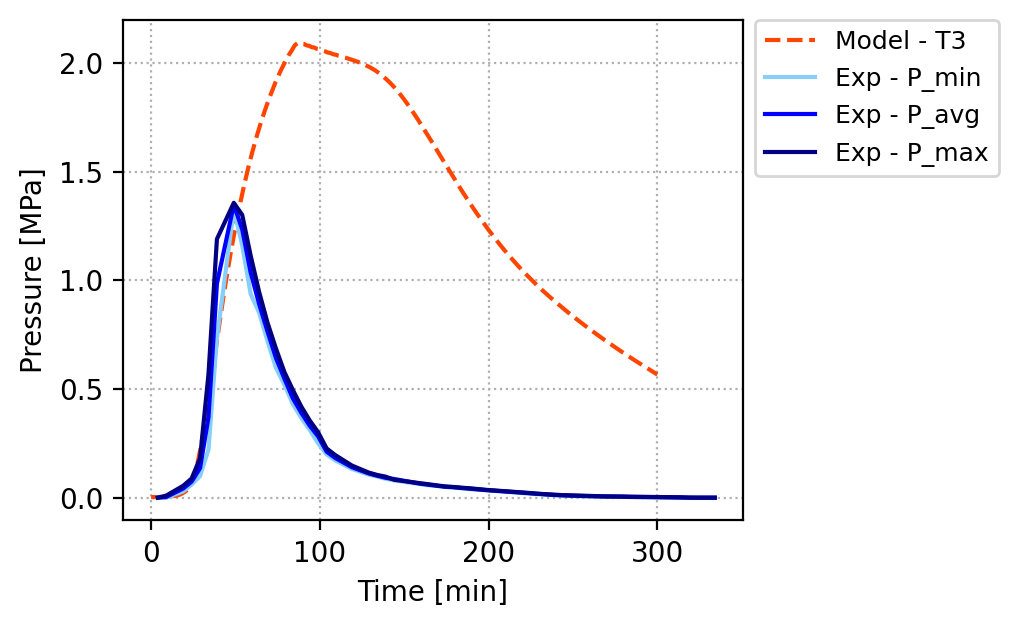

In [18]:
fig = plt.figure(figsize=(4, 3.25), dpi=200)
ts = np.linspace(0, 5 * 3600, 5 * 3600//5 + 1) / 60
plt.plot(ts, P_v_RAM_nodes[:, -40] * 1e-6, c='orangered', ls='--', marker='', markevery=50, label='Model - T3')
plt.plot(df['t_1'], df['Pmin_40mm'] / 10, c='lightskyblue', label='Exp - P_min')
plt.plot(df['t_1'], df['Pavg_40mm'] / 10, c='blue', label='Exp - P_avg')
plt.plot(df['t_1'], df['Pmax_40mm'] / 10, c='navy', label='Exp - P_max')

plt.ylabel('Pressure [MPa]')
plt.xlabel('Time [min]')

plt.grid(ls=':')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.025), fontsize=9)
# plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.25), fontsize=9)

plt.show()

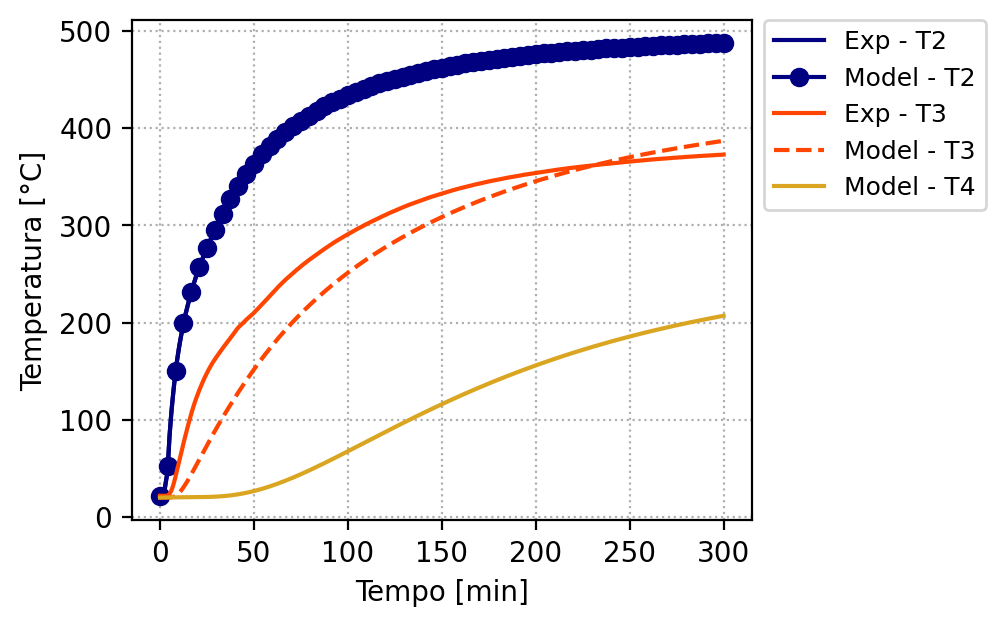

In [118]:
fig = plt.figure(figsize=(4, 3.25), dpi=200)
ts = np.linspace(0, 5 * 3600, 5 * 3600//5 + 1) / 60

plt.plot(df['t_2'], df['T_2'], c='navy', label='Exp - T2')
plt.plot(ts, T_RAM_nodes[:, -1], c='navy', marker='o', markevery=50, label='Model - T2')
plt.plot(df['t_2'], df['T_3'], c='orangered', label='Exp - T3')
plt.plot(ts, T_RAM_nodes[:, -40], c='orangered', ls='--', marker='', markevery=50, label='Model - T3')

plt.plot(ts, T_RAM_nodes[:, 0], c='goldenrod', label='Model - T4')

plt.ylabel('Temperatura [°C]')
plt.xlabel('Tempo [min]')

plt.grid(ls=':')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.025), fontsize=9)
# plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.25), fontsize=9)

plt.show()

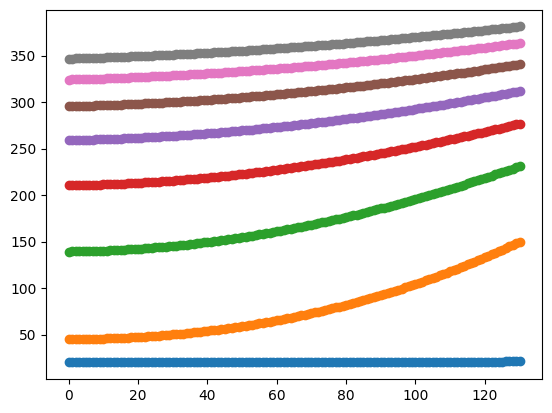

In [74]:
T_RAM_nodes.shape

for i in [0,100,200,300,400,500,600,700]:
    plt.plot(T_RAM_nodes[i], '-o')



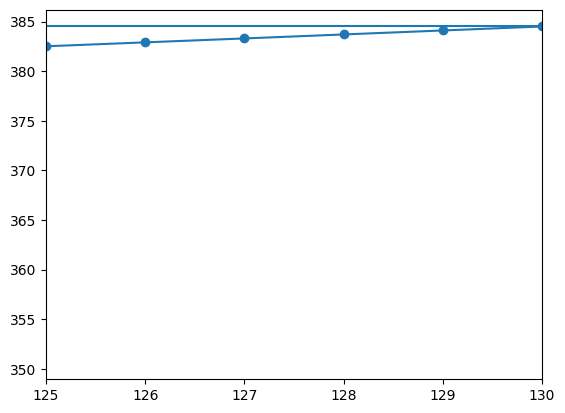

In [69]:
T_RAM_nodes.shape

# for i in [0,100,200,300,400,500,600,700]:
plt.plot(T_RAM_nodes[-1], '-o')
plt.xlim(125, 130)

plt.axhline(384.5)

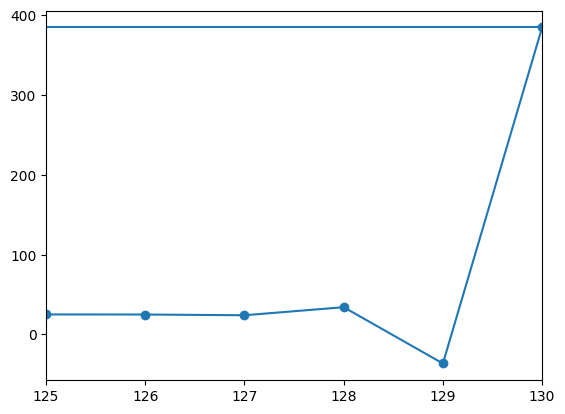

In [61]:
T_RAM_nodes.shape

# for i in [0,100,200,300,400,500,600,700]:
plt.plot(T_RAM_nodes[-1], '-o')
plt.xlim(125, 130)

plt.axhline(384.5)

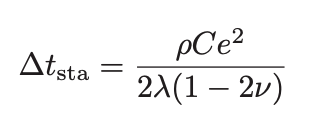

\begin{equation}
\Delta t \leq \Delta t_\text{sta} = \frac{\rho C_p h^2}{2 \lambda (1 - 2 \nu)} \tag{1}
\end{equation}

Para o nosso caso (solver explícito), $\nu = 0$, logo:

\begin{equation}
\Delta t \leq \Delta t_\text{sta} = \frac{\rho C_p h^2}{2 \lambda} \tag{2}
\end{equation}

In [62]:
(rho(25) * (1e-3)**3 * Cp(25) * (1)**2)/ (2 * lmbda(25) * (1e3))

3.15e-08

In [65]:
(rho(25) * Cp(25) * 0.001**2)/ (2 * lmbda(25))

0.0315